In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('../../data/greek_gods_dataset.csv')
colors = ["#F5B7B1", "#AF7AC5", "#85C1E9", "#F5D3B3", "#A2D9CE", "#F9E79F", "#F6A5C0"]



In [6]:
df.describe()

,name_english,name_greek,description,main_type,sub_type
count,444,444,396,444,444
unique,432,442,395,3,6
top,Attis,Ζεύς,spirits of fighting and combat,god,god
freq,2,2,2,290,264


In [7]:
df[df["main_type"] == "personification"]["name_english"].head(20)


4           Achlys
5            Achos
10       Adephagia
11          Adikia
17          Aergia
21    Agathodaemon
23            Agon
24           Aidos
25            Aisa
27           Alala
28         Alastor
32        Aletheia
34            Alke
38       Amechania
41        Anaideia
42          Ananke
44         Angelia
46            Ania
47         Anteros
51           Apate
Name: name_english, dtype: object

In [8]:
df[(df["main_type"] == "god") & (df["name_english"].str[0].str.lower() == "e")]["name_english"].head(20)



144           Echo
145       Eidothea
146     Eileithyia
150        Electra
154         Empusa
155       Enyalius
156           Enyo
158        Epiales
159       Epidotes
160       Epimedes
161    Epimeliades
163         Epione
165         Erebus
166       Eridanos
168           Eros
169           Ersa
173       Eunostus
176      Euronotus
177        Eurotas
178          Eurus
Name: name_english, dtype: object

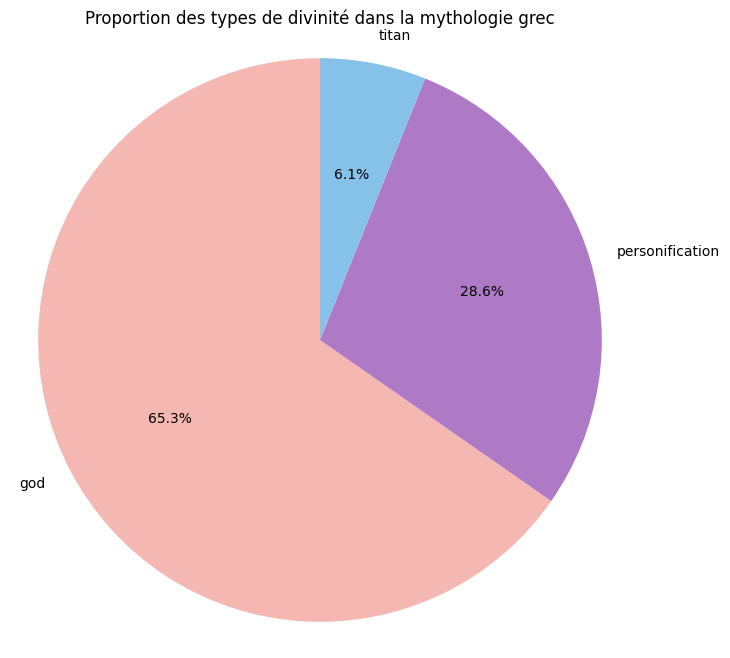

In [7]:
type_counts = df['main_type'].value_counts()

type_percentages = type_counts / type_counts.sum() * 100

plt.figure(figsize=(8, 8))

plt.pie(type_percentages, labels=type_percentages.index,colors=colors, autopct='%1.1f%%', startangle=90)

plt.title("Proportion des types de divinité dans la mythologie grec")
plt.axis('equal') 
plt.show()

In [ ]:
''' 
On constate qu'il existe 3 types de divinité : les titans, les dieux, et les personnifications
Sachant que dans l'ordre, il existe les titans qui ont créé les dieux, et les personnifications sont à part
1er problème : il y a un trop grand nombre de dieu par rapport aux titans ou à la personnification 
donc il sera probable que l'entrainement du modèle y soit affecté
'''

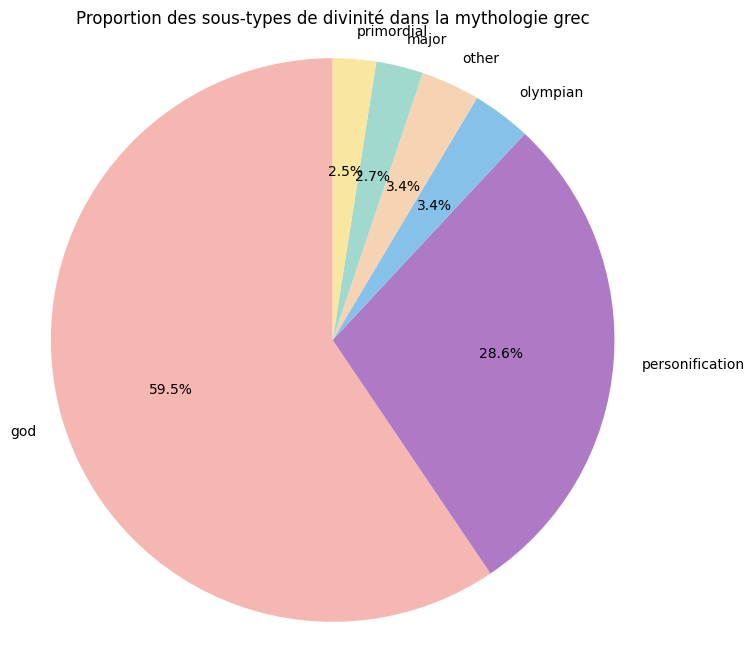

In [19]:
type_counts = df['sub_type'].value_counts()

type_percentages = type_counts / type_counts.sum() * 100

plt.figure(figsize=(8, 8))
plt.pie(type_percentages, labels=type_percentages.index, colors=colors, autopct='%1.1f%%', startangle=90)

plt.title("Proportion des sous-types de divinité dans la mythologie grec")
plt.axis('equal') 
plt.show()

In [17]:
df['sub_type'].value_counts().reset_index()


,sub_type,count
0,god,264
1,personification,127
2,olympian,15
3,other,15
4,major,12
5,primordial,11


In [ ]:
''' 
2nd problème : 
la catégorie "dieu" est trop importante par rapport aux autres catégories de divinité, 
donc le modèle ne retournera presque jamais les "petites" catégories
'''

In [3]:
''' 
Maintenant, du côté des noms en eux même, on remarque qu'ils sont trop peu, mais  un nom est composé de syllabes qui peuvent se ressembler entre plusieurs divinités.
Pour faire différentes opérations et limiter l'impact du peu de nom récolté, nous allons découper ces derniers par syllabe, afin de mieux remarquer les tendances.
'''
def cut_name_to_syllabes(name):
    voyelles = "aeiouy"
    syllabes = []
    syllabe = ""

    for i, char in enumerate(name.lower()):
        syllabe += char
        if char in voyelles:
            if i + 1 == len(name) or name[i + 1].lower() not in voyelles:
                syllabes.append(syllabe)
                syllabe = "" 

    if syllabe:
        syllabes.append(syllabe)

    return syllabes

df['tokens'] = df['name_english'].apply(cut_name_to_syllabes)
df

,name_english,name_greek,description,main_type,sub_type,tokens
0,Zeus,Ζεύς,"King of the gods, ruler of Mount Olympus, and ...",god,olympian,"[ zeu, s]"
1,Aceso,Ἀκεσώ,goddess of the healing of wounds and the curin...,god,god,"[a, ce, so]"
2,Achelous,Αχέλους,NaN,god,god,"[a, che, lou, s]"
3,Acheron,Αχέρων,the river of woe,god,god,"[a, che, ro, n]"
4,Achlys,Ἀχλύς,"spirit of the death-mist, personification of s...",personification,personification,"[a, chly, s]"
...,...,...,...,...,...,...
439,Uranus,Οὐρανός,Οὐρανός (Ouranós),god,primordial,"[u, ra, nu, s]"
440,Zagreus,Ζαγρεύς,"an underworld god, possibly a son of Zeus and ...",god,god,"[za, greu, s]"
441,Zelos,Ζῆλος,"spirit of eager rivalry, emulation, envy, jeal...",personification,personification,"[ze, lo, s]"
442,Zephyrus,Ζέφυρος,god of the west wind,god,god,"[ze, phy, ru, s]"


In [43]:
'''
Maintenant, on peut chercher à compter le nombre de token, moins il y en a, et plus on pourra facilement les réutiliser
'''
all_tokens = [token for sublist in df['tokens'] for token in sublist]
unique_tokens = set(all_tokens) 
num_unique_tokens = len(unique_tokens)
num_unique_tokens

# nous avons 404 syllabes uniques, à partir de ça nous pourrons faire des traitements sans se reposer sur des noms entiers, uniques par définition, et complexifiant le modèle inutilement


404

In [ ]:
total_tokens = df['tokens'].apply(len).sum()
total_tokens


1457

In [58]:
df[(df["main_type"] == "god") & (df["name_english"].str[0].str.lower() == "e")][["name_english", "tokens"]].head(20)

df["tokens"].describe()

count             444
unique            432
top       [a, tti, s]
freq                2
Name: tokens, dtype: object